Import everything we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from astropy.io import ascii
import matplotlib
%matplotlib inline

The following function calculates the boundary of each quartile based on concentration.

In [2]:
def get_percentile():
    rootdir = '/Users/catherinefielder/Documents/Research_Halos/HaloDetail'
    cs = []
    for subdir, dirs, files in os.walk(rootdir):
        head,tail = os.path.split(subdir)
        for file in files:
            if file.endswith('_columnsadded_final'):
                values = ascii.read(os.path.join(subdir, file), format = 'commented_header') #Get full path and access file
                c = values[1]['host_c']                                                     #Grab the host concentration
                cs = np.append(cs, c)
    twentyfifth = np.percentile(cs, 25)
    fifty = np.percentile(cs, 50)
    seventyfifth = np.percentile(cs, 75)
    return twentyfifth, fifty, seventyfifth 

The following function gets the rmax and vmax, and plots it.

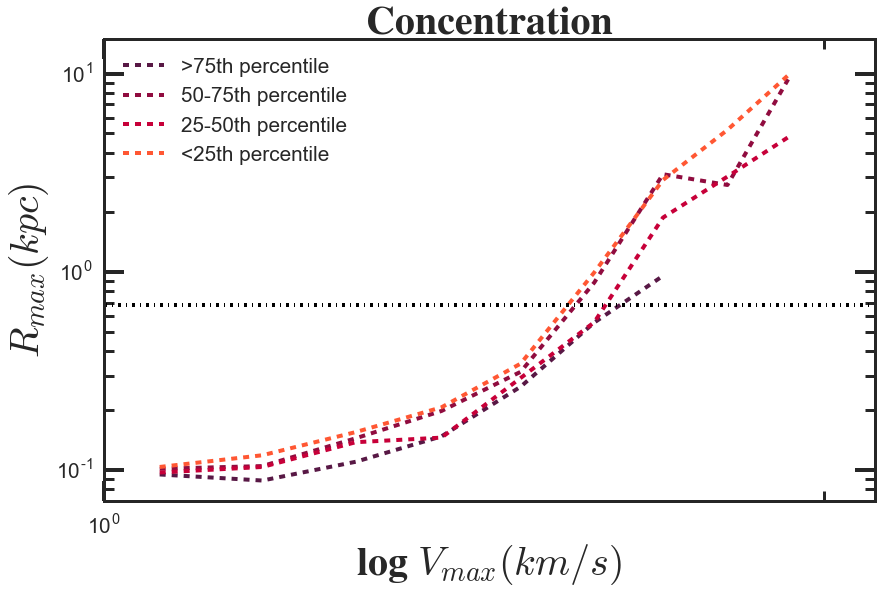

In [5]:
def plotting():
    twentyfifth, fifty, seventyfifth = get_percentile()
    rootdir = '/Users/catherinefielder/Documents/Research_Halos/HaloDetail'
    rmax25s = []
    vel25s = []
    rmax50s = []
    vel50s = []
    rmax75s = []
    vel75s = []
    rmaxxs = []
    velxs = []
    all_vmaxs = []
    for subdir, dirs, files in os.walk(rootdir):
        head,tail = os.path.split(subdir)
        for file in files:
            if file.endswith('_columnsadded_final'):
                values = ascii.read(os.path.join(subdir, file), format = 'commented_header') #Get full path and access file
                c = values[1]['host_c'] 
                #Apply velocity cutoff for resolution
                whlimit = np.where((values['vmax(16)']<100.) & (values['vmax(16)']>10.))
                #Sort each host into a quartile
                if c >= seventyfifth:
                    #Calculate rmax from rs, because Rockstar does not give rmax
                    rmax75 = (values[whlimit]['rs(12)'])*2.16
                    vel75 = values[whlimit]['vmax(16)']
                    #Append
                    rmax75s = np.append(rmax75s, rmax75)
                    vel75s = np.append(vel75s, vel75)   
                if c >= fifty and c < seventyfifth:
                    rmax50 = (values[whlimit]['rs(12)'])*2.16
                    vel50 = values[whlimit]['vmax(16)']
                    rmax50s = np.append(rmax50s, rmax50)
                    vel50s = np.append(vel50s, vel50)
                if  c < fifty and c >= twentyfifth:
                    rmax25 = (values[whlimit]['rs(12)'])*2.16
                    vel25 = values[whlimit]['vmax(16)']
                    rmax25s = np.append(rmax25s, rmax25)
                    vel25s = np.append(vel25s, vel25)
                if c < twentyfifth:
                    rmaxx = (values[whlimit]['rs(12)'])*2.16
                    velx = values[whlimit]['vmax(16)']
                    rmaxxs = np.append(rmaxxs, rmaxx)
                    velxs = np.append(velxs, velx) 
                #Get all of the vmaxs of all of he subhalos for calculating bins
                all_vmax = values[whlimit]['vmax(16)']
                all_vmaxs = np.append(all_vmaxs, all_vmax)     
    #BINNING SECTION
    total_bins = 10
    #logspace the bins
    bins = np.linspace(np.log10(all_vmaxs.min()),np.log10(all_vmaxs.max()),total_bins)
    #Separation of the bins for plotting purposes
    delta = bins[1]-bins[0]

    #Place each quartile into the bins
    idx75  = np.digitize(np.log10(vel75s),bins)
    #Calculate the median in rmax for each bin
    running_median75 = [np.median(rmax75s[idx75==k]) for k in range(total_bins)]
    #Calculate std for errorbars
    #running_std75 = [np.log10(rmax75)[idx75==k].std() for k in range(total_bins)]

    idx50  = np.digitize(np.log10(vel50s),bins)
    running_median50 = [np.median(rmax50s[idx50==k]) for k in range(total_bins)]
    
    idx25  = np.digitize(np.log10(vel25s),bins)
    running_median25 = [np.median(rmax25s[idx25==k]) for k in range(total_bins)]
    
    idxx  = np.digitize(np.log10(velxs),bins)
    running_medianx = [np.median(rmaxxs[idxx==k]) for k in range(total_bins)]
 
    #PLOTTING SECTION
    fig = plt.figure()
    axis_font = {'fontname':'STIXGeneral','size':'40', 'weight':'bold'}
    plt.title('Concentration', **axis_font)
    ax = fig.add_subplot(111)

    #Make the plots
    plt.plot(bins-delta/2,running_median75,'--',lw=4,alpha=1,color='#581845',label='>75th percentile')
    plt.plot(bins-delta/2,running_median50,'--',lw=4,alpha=1,color='#900C3F',label='50-75th percentile')
    plt.plot(bins-delta/2,running_median25,'--',lw=4,alpha=1,color='#C70039',label='25-50th percentile')
    plt.plot(bins-delta/2,running_medianx,'--',lw=4,alpha=1,color='#FF5733',label='<25th percentile')

    #MW data to incluce if desired
    vmaxMW = np.array([13.0, 18.0, 19.0, 13.0, 9.7, 17.0, 14.0, 15.0, 18.0, 19.0, 5.0, 16.0, 9.1, 10.0, 18.0, 11.0, 11.0, 8.3])
    rmaxMW = np.array([0.59, 0.81, 0.86, 0.64, 0.52, 1.0, 0.84, 1.1, 1.5, 1.7, 0.35, 1.2, 0.42, 0.43, 1.5, 0.67, 0.69, 0.38])
    #plt.scatter(rmaxMW, vmaxMW)

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.xlim(xmin=1.0, xmax=2.1)
    plt.ylim(ymin=0.07, ymax=15.)
    plt.ylabel('$R_{max} (kpc)$',**axis_font)
    plt.xlabel('log $V_{max} (km/s)$',**axis_font)
    plt.setp(ax.spines.values(), linewidth=3)
    plt.legend(loc='best')
    sns.set_style("whitegrid")
    sns.set(style='ticks', palette='Set2')
    sns.set_context("poster", font_scale=1.3)
    matplotlib.rcParams['xtick.major.size'] = 20
    matplotlib.rcParams['xtick.major.width'] = 4
    matplotlib.rcParams['xtick.minor.size'] = 10
    matplotlib.rcParams['xtick.minor.width'] = 3
    matplotlib.rcParams['ytick.major.size'] = 20
    matplotlib.rcParams['ytick.major.width'] = 4
    matplotlib.rcParams['ytick.minor.size'] = 10
    matplotlib.rcParams['ytick.minor.width'] = 3
    ax.get_yaxis().set_tick_params(which='both', direction='in')
    ax.get_xaxis().set_tick_params(which='both', direction='in')
    plt.tick_params(axis='y', which='minor')         
    plt.axhline(y=0.68, linewidth = 4, color='k', linestyle='-.')
    plt.tight_layout()
    plt.show()
plotting()